#### 1) Input > RBM1 > BP > Input > RBM2 > BP

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class RBM(nn.Module):
    def __init__(self, W, v_bias, h_bias):
        super(RBM, self).__init__()
        self.W = nn.Parameter(W)
        self.v_bias = nn.Parameter(v_bias)
        self.h_bias = nn.Parameter(h_bias)

    def forward(self, v):
        v = v.float()
        h = torch.sigmoid(torch.matmul(v, self.W) + self.h_bias)
        return h

    def backward(self, h):
        #h = h.float()
        v = torch.sigmoid(torch.matmul(h, self.W.t()) + self.v_bias)
        return v
    
    def contrastive_divergence(self, v):
        h = self.forward(v)
        v1 = self.backward(h)
        print('---------------------------------------------------')
        print('v:', v)
        print('h:', h)
        print('v1:', v1)
        #print('---------------------------------------------------')
        v = v.float()
        h = h.float()
        v1 = v1.float()
        
        v = v.unsqueeze(1)
        v1 = v1.unsqueeze(1)
        h = h.unsqueeze(0)
        
        positive_grad = torch.matmul(v, h)
        negative_grad = torch.matmul(v1, h)
        w_g = positive_grad - negative_grad
        
        v = v.squeeze(1)
        v1 = v1.squeeze(1)
        h = h.squeeze(0)
        
        v_b_g = torch.mean(v - v1)
        h_b_g = torch.mean(h - h)
        
        recon_error = torch.mean(v - v1)**2
        return recon_error, w_g, v_b_g, h_b_g

In [4]:
def min_max_normalization(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

# Sample data
data = np.array([50, 30, 15, 20])

# Min-Max Normalization
normalized_data = min_max_normalization(data)
b_normalized_data = torch.tensor(normalized_data)

print(b_normalized_data)

tensor([1.0000, 0.4286, 0.0000, 0.1429], dtype=torch.float64)


In [11]:
# Example usage:
visible_units = 4  
hidden_units_rbm1 = 3
hidden_units_rbm2 = 2
W1 = torch.randn(visible_units, hidden_units_rbm1)*0.1
W2 = torch.randn(hidden_units_rbm1, hidden_units_rbm2)*0.1
v_bias = torch.randn(visible_units)
h1_bias = torch.randn(hidden_units_rbm1)
h2_bias = torch.randn(hidden_units_rbm2)
learning_rate = 0.1


recon_error_1 = []
for i in range(100):
    rbm1 = RBM(W1, v_bias, h1_bias)
    recon_error, w_g, v_b_g, h_b_g = rbm1.contrastive_divergence(b_normalized_data)
    W1 += learning_rate*w_g
    v_bias += learning_rate*v_b_g
    h1_bias += learning_rate*h_b_g
    recon_error_1.append(recon_error)

print('========================')
#print(recon_error_1)    
recon_error_2 = []
for j in range(150):
    rbm2 = RBM(W2, h1_bias, h2_bias)
    h = torch.sigmoid(torch.matmul(b_normalized_data.float(), W1) + h1_bias)
    recon_error, w_g, v_b_g, h_b_g = rbm2.contrastive_divergence(h)
    W2 += learning_rate*w_g
    h1_bias += learning_rate*v_b_g
    h2_bias += learning_rate*h_b_g
    recon_error_2.append(recon_error)

---------------------------------------------------
v: tensor([1.0000, 0.4286, 0.0000, 0.1429], dtype=torch.float64)
h: tensor([0.2593, 0.3945, 0.5451], grad_fn=<SigmoidBackward0>)
v1: tensor([0.4101, 0.2936, 0.3762, 0.3723], grad_fn=<SigmoidBackward0>)
---------------------------------------------------
v: tensor([1.0000, 0.4286, 0.0000, 0.1429], dtype=torch.float64)
h: tensor([0.2624, 0.4003, 0.5534], grad_fn=<SigmoidBackward0>)
v1: tensor([0.4184, 0.2957, 0.3723, 0.3701], grad_fn=<SigmoidBackward0>)
---------------------------------------------------
v: tensor([1.0000, 0.4286, 0.0000, 0.1429], dtype=torch.float64)
h: tensor([0.2655, 0.4061, 0.5617], grad_fn=<SigmoidBackward0>)
v1: tensor([0.4269, 0.2979, 0.3682, 0.3679], grad_fn=<SigmoidBackward0>)
---------------------------------------------------
v: tensor([1.0000, 0.4286, 0.0000, 0.1429], dtype=torch.float64)
h: tensor([0.2686, 0.4120, 0.5699], grad_fn=<SigmoidBackward0>)
v1: tensor([0.4357, 0.3001, 0.3639, 0.3655], grad_fn=<Sig

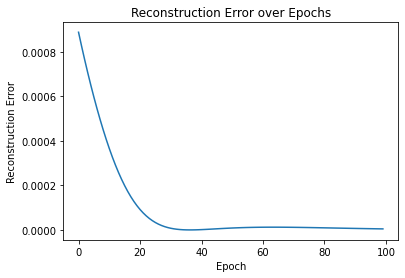

In [12]:
import torch
import matplotlib.pyplot as plt

# Example tensor list
tensor_list = recon_error_1

# Convert tensor list to numpy array
numpy_array = torch.stack(tensor_list).detach().numpy()

# Plot
plt.plot(numpy_array.T)  # Transpose the array for proper plotting
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error over Epochs')
plt.show()


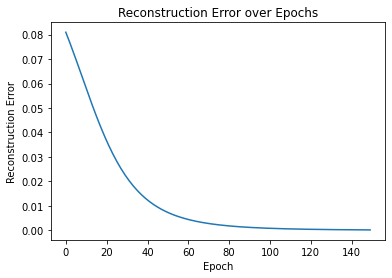

In [13]:
import torch
import matplotlib.pyplot as plt

# Example tensor list
tensor_list = recon_error_2

# Convert tensor list to numpy array
numpy_array = torch.stack(tensor_list).detach().numpy()

# Plot
plt.plot(numpy_array.T)  # Transpose the array for proper plotting
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error over Epochs')
plt.show()


In [14]:
def regenerate_input(v):
    # Generate hidden activations
    h1 = torch.sigmoid(torch.matmul(v.float(), W1) + h1_bias)
    h2 = torch.sigmoid(torch.matmul(h1, W2) + h2_bias)
    h1_recon = torch.sigmoid(torch.matmul(h2, W2.t()) + h1_bias)
    v_recon = torch.sigmoid(torch.matmul(h1_recon, W1.t()) + v_bias)
    return v_recon

# Example usage:
regenerated_input = regenerate_input(b_normalized_data)
print(regenerated_input)

tensor([0.9561, 0.4540, 0.0443, 0.1295], grad_fn=<SigmoidBackward0>)


In [24]:
import torch
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(original_data, regenerated_data):
    # Convert tensors to numpy arrays
    original_data_np = original_data.detach().numpy()
    regenerated_data_np = regenerated_data.detach().numpy()

    # Calculate Mean Squared Error (MSE)
    mse = ((original_data_np - regenerated_data_np) ** 2).mean()

    # Calculate Structural Similarity Index (SSIM) with appropriate window size
    min_side = min(original_data_np.shape[-2:])
    win_size = min(7, min_side)  # Ensure window size is smaller than or equal to the smaller side of the images
    # Ensure window size is odd
    win_size = win_size if win_size % 2 == 1 else win_size - 1
    ssim_value = ssim(original_data_np, regenerated_data_np, win_size=win_size, data_range=original_data_np.max() - original_data_np.min())

    return mse, ssim_value

# Example usage:
mse, ssim_value = calculate_metrics(b_normalized_data, regenerated_input)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Structural Similarity Index (SSIM): {ssim_value}")


Mean Squared Error (MSE): 0.10133391399759911
Structural Similarity Index (SSIM): 0.36084932478330045


#### 2) Input > RBM1 > RBM2 > Back Propagation 

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [35]:
class RBM(nn.Module):
    def __init__(self, W1, W2, v_bias, h1_bias, h2_bias):
        super(RBM, self).__init__()
        self.W1 = nn.Parameter(W1)
        self.W2 = nn.Parameter(W2)
        self.v_bias = nn.Parameter(v_bias)
        self.h1_bias = nn.Parameter(h1_bias)
        self.h2_bias = nn.Parameter(h2_bias)

    def forward(self, v):
        v = v.float()
        h1 = torch.sigmoid(torch.matmul(v, self.W1) + self.h1_bias)
        h2 = torch.sigmoid(torch.matmul(h1, self.W2) + self.h2_bias)
        return h2

    def backward(self, h2):
        h1 = torch.sigmoid(torch.matmul(h2, self.W2.t()) + self.h1_bias)
        v = torch.sigmoid(torch.matmul(h1, self.W1.t()) + self.v_bias)
        return v
    
    def contrastive_divergence(self, v):
        h2 = self.forward(v)
        v_recon = self.backward(h2)
        v = v.float()
        h2 = h2.float()
        #v1 = v1.float()
        
        v = v.unsqueeze(1)
        v_recon = v_recon.unsqueeze(1)
        h2 = h2.unsqueeze(0)
        
        positive_grad = torch.matmul(v, h2)
        negative_grad = torch.matmul(v_recon, h2)
        w_g = torch.mean(positive_grad - negative_grad)
        
        v = v.squeeze(1)
        v_recon = v_recon.squeeze(1)
        h2 = h2.squeeze(0)
        
        v_b_g = torch.mean(v - v_recon)
        recon_error = torch.mean(v - v_recon)**2

        return recon_error, w_g, v_b_g

In [16]:
def min_max_normalization(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

# Sample data
data = np.array([50, 30, 15, 20])

# Min-Max Normalization
normalized_data = min_max_normalization(data)
b_normalized_data = torch.tensor(normalized_data)

print(b_normalized_data)

tensor([1.0000, 0.4286, 0.0000, 0.1429], dtype=torch.float64)


In [40]:
# Example usage:
visible_units = 4  
hidden_units_rbm1 = 64
hidden_units_rbm2 = 128
W1 = torch.randn(visible_units, hidden_units_rbm1)*0.1
W2 = torch.randn(hidden_units_rbm1, hidden_units_rbm2)*0.1
v_bias = torch.randn(visible_units)
h1_bias = torch.randn(hidden_units_rbm1)
h2_bias = torch.randn(hidden_units_rbm2)
learning_rate = 0.1


recon_error_list = []
for i in range(1000):
    rbm = RBM(W1, W2, v_bias, h1_bias, h2_bias)
    recon_error, w_g, v_b_g = rbm.contrastive_divergence(b_normalized_data)
    W1 += learning_rate*w_g
    W2 += learning_rate*w_g
    v_bias += learning_rate*v_b_g
    h1_bias += learning_rate*v_b_g
    h2_bias += learning_rate*v_b_g
    recon_error_list.append(recon_error)

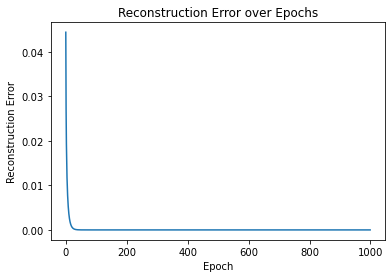

In [41]:
import torch
import matplotlib.pyplot as plt

# Example tensor list
tensor_list = recon_error_list

# Convert tensor list to numpy array
numpy_array = torch.stack(tensor_list).detach().numpy()

# Plot
plt.plot(numpy_array.T)  # Transpose the array for proper plotting
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error over Epochs')
plt.show()


In [47]:
def regenerate_input(v):
    # Generate hidden activations
    h1 = torch.sigmoid(torch.matmul(v.float(), W1) + h1_bias)
    h2 = torch.sigmoid(torch.matmul(h1, W2) + h2_bias)
    h1_recon = torch.sigmoid(torch.matmul(h2, W2.t()) + h1_bias)
    v_recon = torch.sigmoid(torch.matmul(h1_recon, W1.t()) + v_bias)
    return v_recon

# Example usage:
regenerated_input = regenerate_input(b_normalized_data)
print(regenerated_input)

tensor([0.4710, 0.3477, 0.1016, 0.6512], grad_fn=<SigmoidBackward0>)


In [15]:
import torch
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(original_data, regenerated_data):
    # Convert tensors to numpy arrays
    original_data_np = original_data.detach().numpy()
    regenerated_data_np = regenerated_data.detach().numpy()

    # Calculate Mean Squared Error (MSE)
    mse = ((original_data_np - regenerated_data_np) ** 2).mean()

    # Calculate Structural Similarity Index (SSIM) with appropriate window size
    min_side = min(original_data_np.shape[-2:])
    win_size = min(7, min_side)  # Ensure window size is smaller than or equal to the smaller side of the images
    # Ensure window size is odd
    win_size = win_size if win_size % 2 == 1 else win_size - 1
    ssim_value = ssim(original_data_np, regenerated_data_np, win_size=win_size, data_range=original_data_np.max() - original_data_np.min())

    return mse, ssim_value

# Example usage:
mse, ssim_value = calculate_metrics(b_normalized_data, regenerated_input)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Structural Similarity Index (SSIM): {ssim_value}")


C:\Users\gklna\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Mean Squared Error (MSE): 0.0011781864194521327
Structural Similarity Index (SSIM): 0.9908606184421558
